In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import torch
from model.decoder.vit_pixel_decoder import VitPixelDecoder
from omegaconf import OmegaConf

from janus.models import MultiModalityCausalLM
from util.dataloader import get_dataloader

exp_dir = "/data1/jjc/experiment/decoder/0612_decoder"
# config = OmegaConf.load(os.path.join(exp_dir, "config.yaml"))
config = OmegaConf.load("config/vit_pixel_decoder.yaml")


dataloader = get_dataloader(config.data)
janus = MultiModalityCausalLM.from_pretrained(config.janus_path, trust_remote_code=True)
extractor = janus.vision_model

decoder = VitPixelDecoder(config.decoder)
ckpt = torch.load(os.path.join(exp_dir, "Decoder-decoder-500k"), map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)
decoder.eval();

device = torch.device("cpu")
dtype = torch.float32

decoder = decoder.to(device, dtype)
extractor = extractor.to(device, dtype)


/data/jjc/miniconda3/envs/normal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/data/jjc/miniconda3/envs/normal/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


[2025-06-18 02:24:39,165] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/data/jjc/miniconda3/envs/normal/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/data/jjc/miniconda3/envs/normal/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason w

torch.Size([1, 3, 384, 384])
torch.Size([1, 576, 1024])
torch.Size([1, 3, 384, 384])


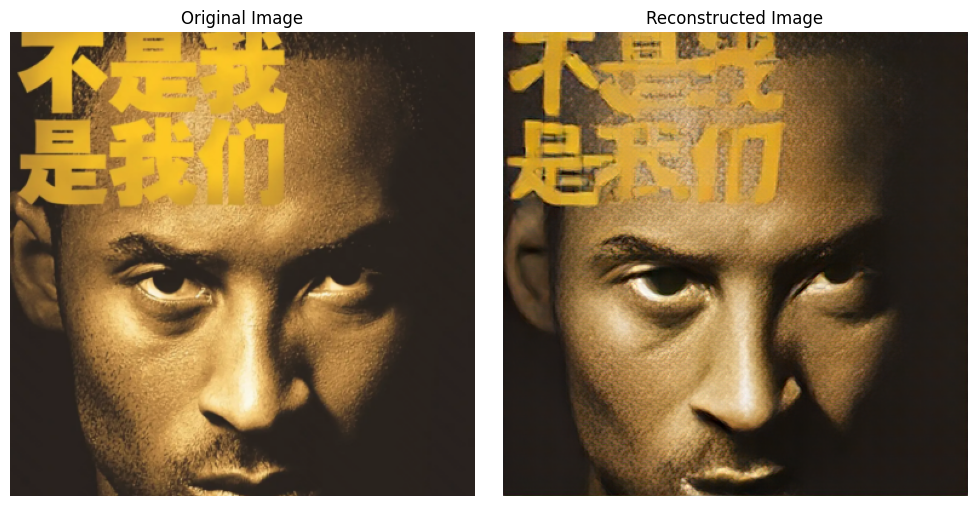

In [2]:
import torchvision.transforms as pth_transforms
# --------- 加载数据 ---------
# batch = next(iter(dataloader))
# x, y = batch

from PIL import Image

img = Image.open("asset/kobe.png")
img = img.convert("RGB")

transform = pth_transforms.Compose([
    pth_transforms.Resize(384, max_size=None),
    pth_transforms.CenterCrop(384),
    pth_transforms.ToTensor(),
    # pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = transform(img)
img = img.unsqueeze(0)
print(img.shape)


# --------- 重建 ---------
with torch.no_grad():
    # ori = x[0].unsqueeze(0).to(device, dtype=dtype)
    ori = img.to(device, dtype=dtype)
    ori = ori * 2 - 1
    feature = extractor(ori)
    print(feature.shape)
    rec = decoder(feature)
    print(rec.shape)

# --------- 绘图 ---------
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

rec_img = ((rec + 1) / 2).clamp(0, 1)
rec_img = inversed_transform(rec_img.squeeze(0))

ori_img = ((ori + 1) / 2).clamp(0, 1)
ori_img = inversed_transform(ori_img.squeeze(0))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rec_img)
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
from PIL import Image

img = Image.open("asset/kobe.png")
img.size
# transform = pth_transforms.Compose([
#     pth_transforms.Resize(384),
#     pth_transforms.ToTensor(),
#     # pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# img = transform(img)

(749, 1103)